This jupyter notebook does the cleaning, preprocessing and annotation of the OTU table obtained from the TotalRNA pipeline after aligning the mRNA to the CaZY database using SWORD. 

This notebook relies in the previous CoMW script and it is coupled to a specific version of the database. 

## How to run Jupyter notebooks in huginn
If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work and run jupyter-lab
```bash
jupyter lab --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```

Please, make sure you have installed the following libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import roman

## Read SWORD file
Our input is a bm9 file, which is not exactly a csv file. The easiest way to read it as a CSV file is to create a temporary file. 

In [2]:
aligned_bm9 = '../results/mRNA/sword/SWORD_CAZy_result.bm9'
!head ../results/mRNA/sword/SWORD_CAZy_result.bm9

# Fields:
Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
TRINITY_DN13529_c0_g1_i4_6	CDU22272.1|GH16	24	266	170	8	169	424	134	378	0.01	116
TRINITY_DN13529_c0_g1_i4_6	BAA36223.1|GH18|3.2.1.14	25	281	163	9	173	442	346	589	0.03	112
TRINITY_DN13529_c0_g1_i4_6	EAA58979.1|GH18|3.2.1.14	25	281	163	9	173	442	346	589	0.03	112
TRINITY_DN13529_c0_g1_i4_6	AAF50522.3|GH22	21	538	333	26	14	491	768	1275	1.78	96
TRINITY_DN13529_c0_g1_i4_6	AAF45644.1|CBM14	22	365	219	18	33	384	786	1099	3.87	93
TRINITY_DN13529_c0_g1_i4_6	ALC44602.1|CBM14	21	627	387	33	5	580	198	764	5.40	91
TRINITY_DN13529_c0_g1_i4_6	ANB13825.1|GH16	23	298	182	10	157	445	267	526	7.60	89
# Fields:


In [3]:
%%bash
grep -v "Query id," < ../results/mRNA/sword/SWORD_CAZy_result.bm9 >  temp_SWORD_CAZy_result.csv

In [4]:
sword = pd.read_csv(
    'temp_SWORD_CAZy_result.csv',delimiter='\t',comment='#', header=None,
    names= ['Query id', 'Subject id', '% identity', 'alignment length', 
             'mismatches','gap openings','q. start', 'q. end',
             's. start', 's. end', 'e-value', 'score'
            ]
)

In [5]:
%%bash
rm  temp_SWORD_CAZy_result.csv

Now, we have a table with all the alignments between our "genes" and the database.

In [6]:
sword

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,TRINITY_DN13529_c0_g1_i4_6,CDU22272.1|GH16,24,266,170,8,169,424,134,378,0.01,116
1,TRINITY_DN13529_c0_g1_i4_6,BAA36223.1|GH18|3.2.1.14,25,281,163,9,173,442,346,589,0.03,112
2,TRINITY_DN13529_c0_g1_i4_6,EAA58979.1|GH18|3.2.1.14,25,281,163,9,173,442,346,589,0.03,112
3,TRINITY_DN13529_c0_g1_i4_6,AAF50522.3|GH22,21,538,333,26,14,491,768,1275,1.78,96
4,TRINITY_DN13529_c0_g1_i4_6,AAF45644.1|CBM14,22,365,219,18,33,384,786,1099,3.87,93
...,...,...,...,...,...,...,...,...,...,...,...,...
1167850,TRINITY_DN59565_c0_g1_i1_2,AEM86141.1|CE4,50,26,12,1,41,66,343,367,8.06,67
1167851,TRINITY_DN59565_c0_g1_i1_2,AEM86141.1|GT2,50,26,12,1,41,66,343,367,8.06,67
1167852,TRINITY_DN59565_c0_g1_i1_2,AEI46304.1|GH43_9,48,31,12,2,17,43,315,345,9.41,66
1167853,TRINITY_DN59565_c0_g1_i1_2,AFC33907.1|GH43_9,48,31,12,2,17,43,315,345,9.41,66


## Read count table
However, we also need to read the count table:

In [7]:
counts_tsv = '../results/mRNA/mapped_reads_to_contigs_AbundanceFiltered.tsv'
! head ../results/mRNA/mapped_reads_to_contigs_AbundanceFiltered.tsv

ContigID	Katie45	Katie54	Katie32	Katie25
TRINITY_DN16047_c0_g1_i1	3	0	2	2
TRINITY_DN3406_c0_g1_i2	0	37	0	4
TRINITY_DN6613_c4_g1_i2	4	18	0	0
TRINITY_DN5543_c0_g1_i2	3	0	4	3
TRINITY_DN60437_c0_g1_i1	0	10	0	1
TRINITY_DN573_c0_g1_i1	0	51	2	2
TRINITY_DN61772_c0_g1_i1	0	8	0	0
TRINITY_DN15263_c0_g1_i1	0	7	0	2
TRINITY_DN2319_c0_g1_i9	48	0	8	27


In [8]:
counts = pd.read_csv(
    counts_tsv, sep = "\t", comment='#'
).set_index('ContigID')
counts

,Katie45,Katie54,Katie32,Katie25
ContigID,,,,
TRINITY_DN16047_c0_g1_i1,3,0,2,2
TRINITY_DN3406_c0_g1_i2,0,37,0,4
TRINITY_DN6613_c4_g1_i2,4,18,0,0
TRINITY_DN5543_c0_g1_i2,3,0,4,3
TRINITY_DN60437_c0_g1_i1,0,10,0,1
...,...,...,...,...
TRINITY_DN48454_c0_g1_i1,4,0,4,2
TRINITY_DN41188_c0_g1_i1,2,0,2,2
TRINITY_DN7932_c0_g2_i1,4,0,2,7


## Preprocessing
### Most significant hit per Contig

Before using Sword, we used transeq to obtain each possible ORF. Let's create a column with the gene name. That is, without the last 2 characters (_ 1, _ 2...) that encode the ORF.

In [9]:
sword['ContigID'] = sword['Query id'].str.replace('_[1-6]$', '', regex=True)
sword['ContigID']

0          TRINITY_DN13529_c0_g1_i4
1          TRINITY_DN13529_c0_g1_i4
2          TRINITY_DN13529_c0_g1_i4
3          TRINITY_DN13529_c0_g1_i4
4          TRINITY_DN13529_c0_g1_i4
                     ...           
1167850    TRINITY_DN59565_c0_g1_i1
1167851    TRINITY_DN59565_c0_g1_i1
1167852    TRINITY_DN59565_c0_g1_i1
1167853    TRINITY_DN59565_c0_g1_i1
1167854    TRINITY_DN59565_c0_g1_i1
Name: ContigID, Length: 1167855, dtype: object

Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

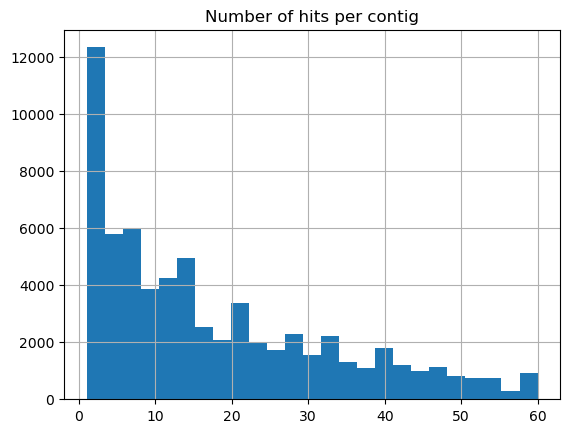

In [10]:
sword.pivot_table(columns=['ContigID'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [11]:
sword = sword.sort_values(
        by=['e-value', 'score'], ascending=[True, False]
        ).drop_duplicates(
    'ContigID', keep='first'
).set_index('ContigID')
sword

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
ContigID,,,,,,,,,,,,
TRINITY_DN737_c0_g1_i7,TRINITY_DN737_c0_g1_i7_3,AAM83096.1|GT2,72,1160,273,20,75,1208,1,1129,0.00,4350
TRINITY_DN737_c0_g1_i2,TRINITY_DN737_c0_g1_i2_3,AAM83096.1|GT2,71,1160,278,20,75,1208,1,1129,0.00,4321
TRINITY_DN737_c0_g1_i1,TRINITY_DN737_c0_g1_i1_3,AAM83096.1|GT2,71,1137,272,20,75,1185,1,1106,0.00,4222
TRINITY_DN2220_c0_g1_i1,TRINITY_DN2220_c0_g1_i1_2,BAZ22996.1|GT35,79,849,177,1,384,1231,3,851,0.00,3600
TRINITY_DN2220_c0_g1_i5,TRINITY_DN2220_c0_g1_i5_2,BAZ22996.1|GT35,79,849,177,1,390,1237,3,851,0.00,3600
...,...,...,...,...,...,...,...,...,...,...,...,...
TRINITY_DN7563_c1_g2_i1,TRINITY_DN7563_c1_g2_i1_1,AAK13500.1|GT21|2.4.1.-,26,89,54,3,12,95,80,161,9.99,68
TRINITY_DN11159_c0_g1_i1,TRINITY_DN11159_c0_g1_i1_5,CCG01471.1|GT51,44,32,18,0,12,43,683,714,9.99,67
TRINITY_DN25731_c0_g1_i1,TRINITY_DN25731_c0_g1_i1_1,AKO44562.1|GT41,35,62,32,3,9,64,160,219,9.99,67


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<Axes: title={'center': 'e-value'}>]], dtype=object)

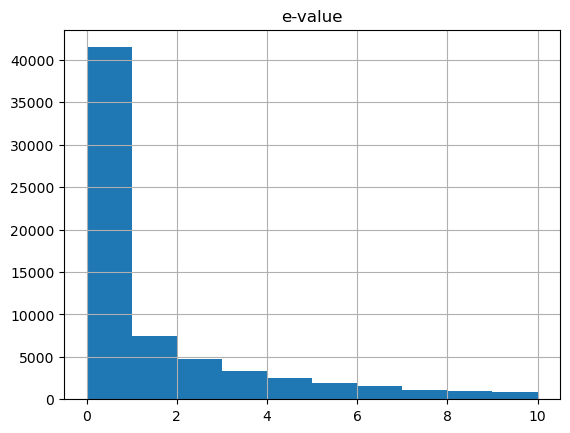

In [12]:
sword.hist("e-value")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

In [13]:
evalue_threshold = 0.001

In [14]:
sword = sword.loc[sword['e-value'] < evalue_threshold] 

array([[<Axes: title={'center': 'e-value'}>]], dtype=object)

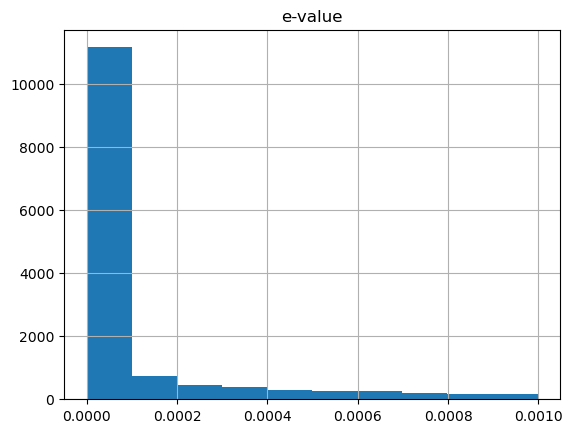

In [15]:
sword.hist("e-value")

In [16]:
val = len(set(sword["Subject id"]))
print(f"There are {val} unique orthologous genes")

There are 3986 unique orthologous genes


### Inspect % identity and aligment length

array([[<Axes: title={'center': 'alignment length'}>]], dtype=object)

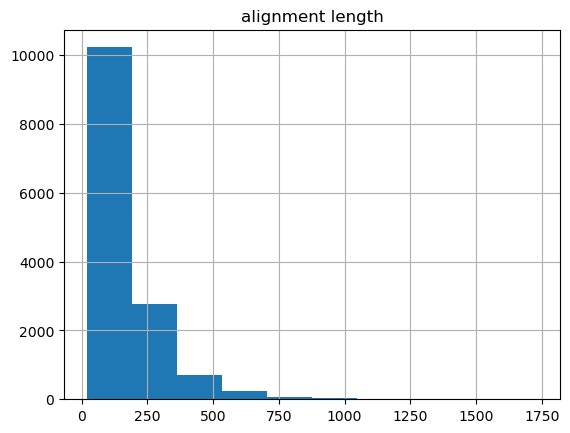

In [17]:
sword.hist("alignment length")

array([[<Axes: title={'center': '% identity'}>]], dtype=object)

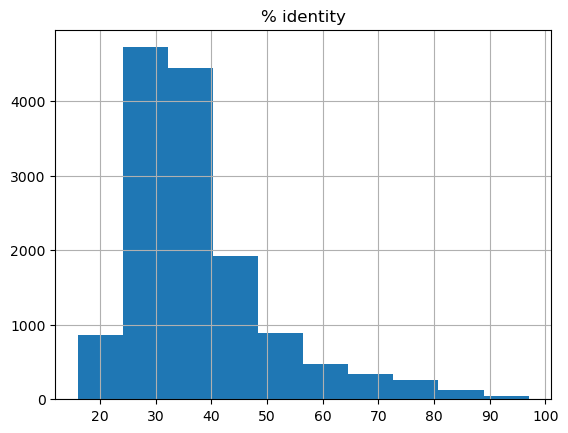

In [18]:
sword.hist("% identity")

### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table). 

In [19]:
map_table = sword[["Query id","Subject id"]]
map_table

,Query id,Subject id
ContigID,,
TRINITY_DN737_c0_g1_i7,TRINITY_DN737_c0_g1_i7_3,AAM83096.1|GT2
TRINITY_DN737_c0_g1_i2,TRINITY_DN737_c0_g1_i2_3,AAM83096.1|GT2
TRINITY_DN737_c0_g1_i1,TRINITY_DN737_c0_g1_i1_3,AAM83096.1|GT2
TRINITY_DN2220_c0_g1_i1,TRINITY_DN2220_c0_g1_i1_2,BAZ22996.1|GT35
TRINITY_DN2220_c0_g1_i5,TRINITY_DN2220_c0_g1_i5_2,BAZ22996.1|GT35
...,...,...
TRINITY_DN12940_c0_g1_i2,TRINITY_DN12940_c0_g1_i2_1,ABA49091.1|GT51
TRINITY_DN4181_c0_g1_i1,TRINITY_DN4181_c0_g1_i1_3,AAF10059.1|GT51
TRINITY_DN39517_c0_g1_i1,TRINITY_DN39517_c0_g1_i1_5,SCF08587.1|GT4


Now, we are going to merge both files by their column in common (ContigID and Subject id).

In [20]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(drop=True)
df

,Query id,Subject id,Katie45,Katie54,Katie32,Katie25
0,TRINITY_DN737_c0_g1_i7_3,AAM83096.1|GT2,94,0,62,94
1,TRINITY_DN737_c0_g1_i2_3,AAM83096.1|GT2,91,0,53,92
2,TRINITY_DN737_c0_g1_i1_3,AAM83096.1|GT2,64,0,33,75
3,TRINITY_DN2220_c0_g1_i1_2,BAZ22996.1|GT35,2,605,3,11
4,TRINITY_DN2220_c0_g1_i5_2,BAZ22996.1|GT35,2,640,2,13
...,...,...,...,...,...,...
12462,TRINITY_DN17852_c0_g1_i1_4,AAP42878.1|GT4,0,8,2,2
12463,TRINITY_DN12940_c0_g1_i2_1,ABA49091.1|GT51,0,24,0,1
12464,TRINITY_DN4181_c0_g1_i1_3,AAF10059.1|GT51,2,8,2,3
12465,TRINITY_DN3288_c0_g1_i5_2,ABC20869.1|GT2,5,0,7,5


### Aggregate table
Now, we are going to aggregate the rows by grouping by "Subject id" (notice the difference in rows between the previous table and the following):

In [21]:
df = df.groupby('Subject id').sum(numeric_only = True)
df

,Katie45,Katie54,Katie32,Katie25
Subject id,,,,
AAA20560.1|GH15|3.2.1.3,0,10,0,2
AAA30255.1|GH33,22,176,47,31
AAA52077.1|CBM8|3.2.1.4,16,0,14,14
AAA52077.1|GH9|3.2.1.4,38,0,57,58
AAA59054.1|GT1|2.4.1.121,0,17,0,4
...,...,...,...,...
XP_503149.1|GH18,5,0,4,2
XP_504217.1|GH17,12,0,38,11
XP_959572.1|GH79,8,0,2,6


## Annotating count table

First, we define a functions for extracting the annotation from the header.

In [22]:
import re
import doctest
def extract_CAZyDB_id(x: str)-> list[str]:
    """
    >>> extract_CAZyDB_id('XP_503149.1|GH18')
    ['GH18']
    >>> extract_CAZyDB_id('AAA52077.1|CBM8|3.2.1.4')
    ['CBM8', '3.2.1.4']
    """
    return x.split('|')[1:]

def get_annotation_from_CAZyDB_id(x: list[str]) -> str:
    """
    >>> get_annotation_from_CAZyDB_id(['GH31'])
    'Glycoside Hydrolases'
    >>> get_annotation_from_CAZyDB_id(['GT75'])
    'GlycosylTransferases'
    >>> get_annotation_from_CAZyDB_id(['AA5', 'CBM18'])
    'Multiple enzyme class'
    >>> get_annotation_from_CAZyDB_id(['CBM49', 'GH9'])
    'Multiple enzyme class'
    >>> get_annotation_from_CAZyDB_id(['QAT16263.1'])
    ''
    """
    symbols = {
        "GH": "Glycoside Hydrolases", "GT": "GlycosylTransferases",
        "PL": "Polysaccharide Lyases", "CE": "Carbohydrate Esterases",
        "AA": "Auxiliary Activities", "CBM": "Carbohydrate-Binding Modules"}
    checks = [any(ann in y for y in x) for ann in  symbols.keys()]
    annotations = [list(symbols.keys())[i] for i, x in enumerate(checks) if x]
    if sum(checks) == 0: return ""
    if sum(checks) > 1: return "Multiple enzyme class"
    return symbols[annotations[0]]
    
# Run tests
doctest.testmod()

TestResults(failed=0, attempted=7)

Now we are going to create a new column with the functions. The format is fixed to match the previous implementation. 

In [23]:
functions_df = pd.DataFrame(index=df.index)
functions_df[f"Level0"] = "DB__CAZy"
cazy_ids = [dict(enumerate(extract_CAZyDB_id(row))) for row in df.index]
functions_df["Level1"] = [f"LevelI__{get_annotation_from_CAZyDB_id(list(row.values()))}" for row in cazy_ids]
n = 5 # To match the number of levels
for index in range(n):
    r = roman.toRoman(index+2)
    prefix = f"Level{r}__"
    functions_df[f"Level{index+2}"] = [f"{prefix}{row.get(index, '')}" for row in cazy_ids]
functions = functions_df.reindex(
    sorted(functions_df.columns), axis=1
    ).astype(str).agg('; '.join, axis=1)
functions

Subject id
AAA20560.1|GH15|3.2.1.3     DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
AAA30255.1|GH33             DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
AAA52077.1|CBM8|3.2.1.4     DB__CAZy; LevelI__Carbohydrate-Binding Modules...
AAA52077.1|GH9|3.2.1.4      DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
AAA59054.1|GT1|2.4.1.121    DB__CAZy; LevelI__GlycosylTransferases; LevelI...
                                                  ...                        
XP_503149.1|GH18            DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
XP_504217.1|GH17            DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
XP_959572.1|GH79            DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
ZP_03681665.1|GT5           DB__CAZy; LevelI__GlycosylTransferases; LevelI...
ZP_03682210.1|GH20          DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
Length: 3436, dtype: object

In [24]:
df["Functions"] = functions
df.reset_index(inplace=True)
df.rename(columns={"Subject id": "ContigID"}, inplace=True)
df

,ContigID,Katie45,Katie54,Katie32,Katie25,Functions
0,AAA20560.1|GH15|3.2.1.3,0,10,0,2,DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
1,AAA30255.1|GH33,22,176,47,31,DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
2,AAA52077.1|CBM8|3.2.1.4,16,0,14,14,DB__CAZy; LevelI__Carbohydrate-Binding Modules...
3,AAA52077.1|GH9|3.2.1.4,38,0,57,58,DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
4,AAA59054.1|GT1|2.4.1.121,0,17,0,4,DB__CAZy; LevelI__GlycosylTransferases; LevelI...
...,...,...,...,...,...,...
3431,XP_503149.1|GH18,5,0,4,2,DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
3432,XP_504217.1|GH17,12,0,38,11,DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
3433,XP_959572.1|GH79,8,0,2,6,DB__CAZy; LevelI__Glycoside Hydrolases; LevelI...
3434,ZP_03681665.1|GT5,22,0,11,6,DB__CAZy; LevelI__GlycosylTransferases; LevelI...


In [25]:
df.to_csv('CaZY_sword_annotated_count_table.tsv', sep="\t", index=False)